In [1]:
pip install matplotlib
pip install wordcloud

SyntaxError: invalid syntax (3893185956.py, line 1)

In [2]:
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable


ERROR: Could not find a version that satisfies the requirement tensorflow (from versions: none)
ERROR: No matching distribution found for tensorflow


In [5]:
!pip install wordcloud

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation,BatchNormalization,Input,Embedding,Dot,Dense,Flatten
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler,TensorBoard,EarlyStopping

from wordcloud import WordCloud
%matplotlib inline

In [7]:
import os

In [8]:
INPUT_DIR = os.path.join("..","artifacts","raw")

In [12]:
rating_df = pd.read_csv(INPUT_DIR+"/animelist.csv",low_memory=True,usecols=["user_id","anime_id","rating"])

In [13]:
rating_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [14]:
len(rating_df)

1000000

In [15]:
n_rating = min(rating_df["rating"])

In [16]:
max_rating = max(rating_df['rating'])

In [17]:
max_rating

10

In [19]:
n_rating

0

In [20]:
avg_rating = np.mean(rating_df['rating'])

In [21]:
avg_rating

np.float64(4.252866)

In [23]:
rating_df.duplicated().sum()

np.int64(0)

In [24]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [25]:
user_ids = rating_df['user_id'].unique().tolist()

user2user_encoded = {x:i for i,x in enumerate(user_ids)}
user2user_decoded = {i:x for i,x in enumerate(user_ids)}
rating_df['user'] = rating_df['user_id'].map(user2user_encoded)

In [42]:
n_users = len(user2user_encoded)

In [43]:
n_user

3135

In [28]:
## 11054 : 12  -> user2user encoded
## 12 : 11054 ---> usser2userdecocded

In [29]:
anime_ids = rating_df["anime_id"].unique().tolist()
anime2anime_encoded = {x:i for i,x in enumerate(anime_ids)}
anime2anime_decoded ={ i:x for i,x in enumerate(anime_ids)}

rating_df['anime'] = rating_df["anime_id"].map(anime2anime_encoded)



In [30]:
n_anime = len(anime2anime_encoded)

In [31]:
n_anime

13265

In [32]:
rating_df = rating_df.sample(frac=1,random_state=43).reset_index(drop=True)

In [33]:
rating_df.head(2)

,user_id,anime_id,rating,user,anime
0,3105,40540,0,2856,2089
1,1698,38759,0,1560,852


In [34]:
X = rating_df[["user","anime"]].values
y = rating_df["rating"]

In [35]:
test_size = 1000
train_indices = rating_df.shape[0]-test_size


In [36]:
X_train,X_test,y_train,y_test = (
    X[:train_indices],
    X[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [37]:
len(X_train)

999000

In [38]:
len(X_test)

1000

In [39]:
type(X_train)

numpy.ndarray

In [40]:
X_train_array = [X_train[:,0],X_train[:,1]]
X_test_array = [X_test[:,0],X_test[:,1]]

In [41]:
type(X_test_array)

list

In [52]:
def RecommenderNet():
    embedding_size = 128

    user = Input(name="user", shape=[1])
    user_embedding = Embedding(name="user_embedding", input_dim=n_users, output_dim=embedding_size)(user)

    anime = Input(name="anime", shape=[1])
    anime_embedding = Embedding(name="anime_embedding", input_dim=n_anime, output_dim=embedding_size)(anime)

    x = Dot(name="dot_product", normalize=True, axes=2)([user_embedding, anime_embedding])
    x = Flatten()(x)
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)

    model = Model(inputs=[user, anime], outputs=x)
    model.compile(loss='binary_crossentropy', metrics=["mae", "mse"], optimizer='Adam')

    return model


In [53]:
model = RecommenderNet()

In [54]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │    401,280 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  1,697,920 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │          2 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1)         │          4 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,099,206 (8.01 MB)

 Trainable params: 2,099,204 (8.01 MB)

 Non-trainable params: 2 (8.00 B)

In [55]:
start_lr = 0.00001
min_lr = 0.0001
max_lr = 0.00005
batch_size = 10000

ramup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8

def lrfn(epoch):
    if epoch<ramup_epochs:
        return (max_lr-start_lr)/ramup_epochs*epoch + start_lr
    elif epoch<ramup_epochs+sustain_epochs:
        return max_lr
    else:
        return (max_lr-min_lr) * exp_decay ** (epoch-ramup_epochs-sustain_epochs)+min_lr

In [56]:
lr_callback = LearningRateScheduler(lambda epoch:lrfn(epoch) , verbose=0)
checkpoint_filepath = './weights.weights.h5'

model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,monitor="val_loss",mode="min",save_best_only=True)

early_stopping = EarlyStopping(patience=3,monitor="val_loss",mode="min",restore_best_weights=True)

In [57]:
my_callbacks = [model_checkpoint,lr_callback,early_stopping]

In [58]:
history = model.fit(
    x=X_train_array,
    y=y_train,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_data = (X_test_array,y_test),
    callbacks=my_callbacks
)

Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - loss: 0.7026 - mae: 4.1752 - mse: 29.4932 - val_loss: 0.6871 - val_mae: 4.0779 - val_mse: 28.7030 - learning_rate: 1.0000e-05
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.6919 - mae: 4.1817 - mse: 29.5567 - val_loss: 0.6808 - val_mae: 4.0778 - val_mse: 28.6998 - learning_rate: 1.8000e-05
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.6760 - mae: 4.1851 - mse: 29.5786 - val_loss: 0.6726 - val_mae: 4.0776 - val_mse: 28.6957 - learning_rate: 2.6000e-05
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.6520 - mae: 4.1818 - mse: 29.5693 - val_loss: 0.6480 - val_mae: 4.0773 - val_mse: 28.6834 - learning_rate: 3.4000e-05
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.6169 - mae: 4.1814 - mse: 29.5563 - val_loss: 0.6319 - val_mae: 4.0769 - val_mse: 28.6754 - learning_rate: 4.2000e-05
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 0.5737 - mae: 4.1754 - mse: 29.480

In [60]:
model.load_weights(checkpoint_filepath)

In [61]:
metrics = ["loss","mae","mse"]

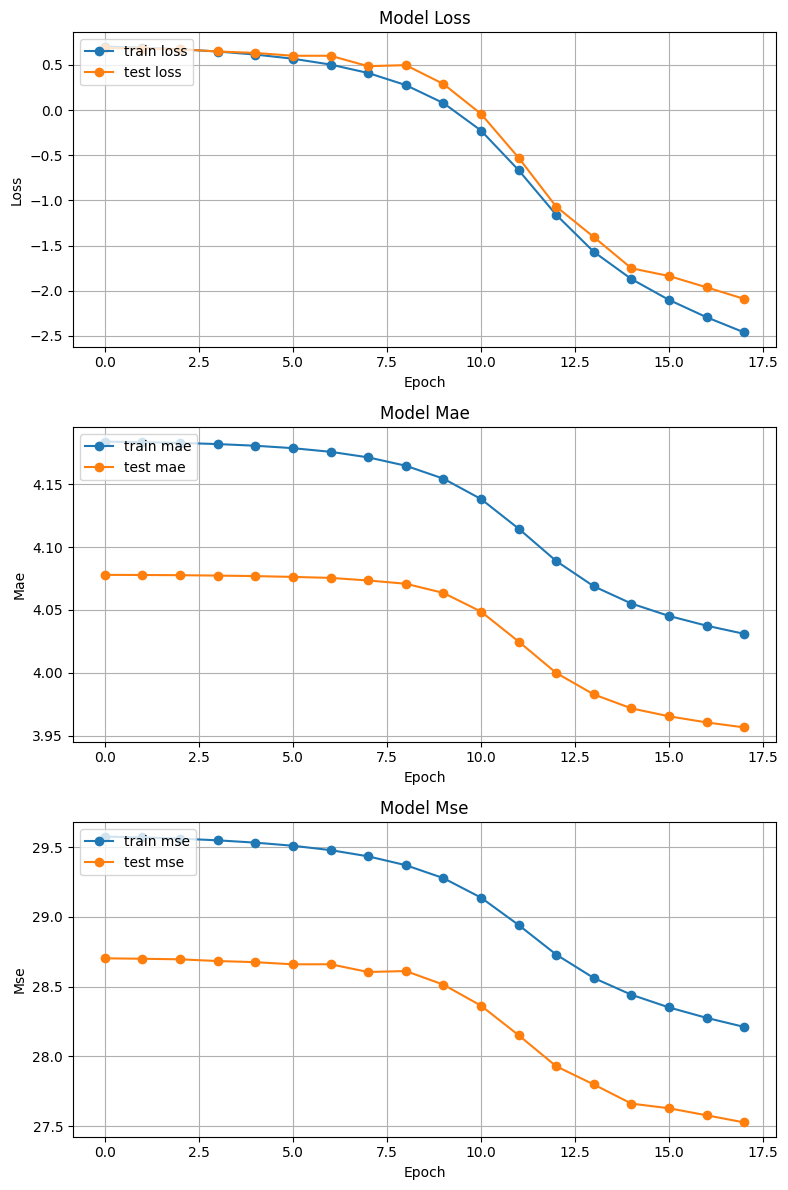

In [62]:
metrics = ["loss", "mae", "mse"]

# Create subplots
fig, axes = plt.subplots(len(metrics), 1, figsize=(8, len(metrics) * 4))

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(history.history[metric][0:-2], marker="o", label=f"train {metric}")
    ax.plot(history.history[f"val_{metric}"][0:-2], marker="o", label=f"test {metric}")
    ax.set_title(f"Model {metric.capitalize()}")
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel("Epoch")
    ax.legend(loc="upper left")
    ax.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
### reading anime list

In [ ]:
import os 
INPUT_DIR = os.path.join("..","artifacts","raw")
